![Banner](img/AI_Special_Program_Banner.jpg)

## Convolutional Neural Networks (CNN) - Material 
---

The material presented is adapted from *Python Machine Learning 3rd Edition* by [Sebastian Raschka](https://sebastianraschka.com) & [Vahid Mirjalili](http://vahidmirjalili.com), Packt Publishing Ltd. 2019 (code available on [GitHub](https://github.com/rasbt/python-machine-learning-book-3rd-edition)).

To finally dive into the more advanced topics of machine learning, this week we will look at one of ML's most popular applications and research areas: object recognition in images, more precisely image classification using a modern approach.

Although we already did some image classification (e.g., recognizing handwritten digits / fashion items with the help of standard ANNs and classifying objects previously), most traditional ML models reach their limits when dealing with inherently more complex tasks (e.g., larger images, more classes, more color channels).

To solve those complex problems (or to get better results on the data we already have seen so far), different types of predictive models are necessary. Arguably, one of the most influential and successful ones (for the domain of image classification) can be found in *Convolutional Neural Networks*. As with Artificial Neural Networks, CNNs have been inspired by nature and biology - to be more precise, by the visual cortex of animals and humans, and how the brain processes visual information ([see the work of Nobel Prize winners David H. Huble and Torsten Wiesel](https://doi.org/10.1113/jphysiol.1959.sp006308)). 

In this notebook, we will look at the theoretical concepts behind convolutional neural networks and also do some hands-on image classification again using `PyTorch`. This time, only other deep learning frameworks would be an alternative, since these more sophisticated deep learning NN architectures lie outside the realm of `scikit-learn`, unfortunately.

## Overview
---

- [The building blocks of convolutional neural networks](#The-building-blocks-of-convolutional-neural-networks)
    - [Feature hierarchies](#Feature-hierarchies)
    - [2-dimensional discrete convolutions](#2-dimensional-discrete-convolutions)
    - [Subsampling layers](#Subsampling-layers)
    - [Putting everything together: Base CNN architecture](#Putting-everything-together:-Base-CNN-architecture)
- [Regularization with Dropout](#Regularization-with-Dropout)
- [Implementing a deep convolutional neural network (MNIST)](#Implementing-a-deep-convolutional-neural-network-(MNIST))
    - [The multilayer CNN architecture](#The-multilayer-CNN-architecture)
    - [Loading and preprocessing the data](#Loading-and-preprocessing-the-data)
    - [Implementing a CNN using PyTorch](#Implementing-a-CNN-using-PyTorch)
        - [Hyperparameters for CNN layers in PyTorch](#Hyperparameters-for-CNN-layers-in-PyTorch)
    - [Building a CNN with PyTorch](#Building-a-CNN-with-PyTorch)
        - [Model training](#Model-training)
        - [Model quality](#Model-quality)
        - [Classification of selected images](#Classification-of-selected-images)
- [Gender classification from face images using CNN](#Gender-classification-from-face-images-using-CNN)
    - [Loading the CelebA dataset](#Loading-the-CelebA-dataset)
    - [Data Augmentation](#Idea:-Data-Augmentation)
        - [Expansion of existing data through random transformation and augmentation](#Expansion-of-existing-data-through-random-transformation-and-augmentation)
    - [Prepare training](#Prepare-training)
    - [Training a CNN gender classifier](#Training-a-CNN-gender-classifier)
    - [Resuming training](#Resuming-training)
    - [Classification of images](#Classification-of-images)
- [Learning Outcomes](#Learning-Outcomes)

---

In [1]:
#import os, os.path
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torch.optim as optim
from tqdm.notebook import trange, tqdm
from PIL import Image
# force gpu computing, when gpu library is available
USE_GPU = True
# for timing
import datetime as dt

/tmp/ipykernel_12926/3362389439.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Training loop and collecting progress information
Having laid the foundation in the [material on Deep Neural Networks](3.1.a_DNN_Mat.ipynb), we are now ready to make use of the functions provided in the file [`train_loop.py`](train_loop.py) and import the ones we need here.

In [2]:
from train_loop import train, train_for_epochs, validate, plot_history

---

## The building blocks of convolutional neural networks

### Feature hierarchies

* Finding *salient features* is, generally, very important for ML algorithms
* However, it is especially important in pictures
* CNNs are often considered as *feature extractors*: lower layers extract features (in *hierarchies*), higher ones use those extractions for predictions
* *Feature maps* are based on the local *receptive field* (see picture below)
* multiple layers lead to *feature hierarchies*

<img src="./img/15_01.png" width=700/>
<div style="text-align: right"><i>Photo by Alexander Dummer on Unsplash</i></div>

**Basic Ideas**:
* Areas of the feature map  are only connected to few pixels from the input image (*sparse connectivity*) $\leftarrow$ direct surroundings (nearby pixels) more relevant to feature than the whole image
* Same weights are used for different areas of the input image (*parameter sharing*)

$\rightarrow$ less parameters to learn (in contrast to fully connected networks) and the ability to better caputure salient features

### 2-dimensional discrete convolutions
**Terminology and Principles**:

* *Kernel* (or *Filter*): consists of weights (that need to be learned by backpropagation)
* *Padding* $\rightarrow$ can be applied to influence the size of the feature maps
* A *filter* is shifted over a (possibly) *padded* input by a number of cells. The size of the shift is called *stride* (corresponds to changes in the receptive field)
* Practical implementation: multiplication of *rotated* filter with input field to receive output value

<img src="./img/15_05.png" width=700/>

#### Example
* 3x3 input, 3x3 kernel, 2x2 stride $\rightarrow$ padded input 5x5, output 2x2

<img src="./img/15_06.png" width=700/>

<img src="./img/15_07.png" width=700/>

**Remark**: The rotation (or *flipping*) of the kernel as shown in the figure above is needed in theory. However, the weight matrix can be defined in flipped form already in practice, so it is not necessary to actually perform the flip during compute time.

### Subsampling layers
* Dimensionality reduction (smaller feature size) $\rightarrow$ increased computational efficiency and less overfitting
* *Max-Pooling*: generates features that are more robust to noise in the input data
* Pooling parameters are not learnable

<img src="./img/15_08.png" width=700/>

For more background and animated visualizations see the [second notebook](3.1.b_CNN_2_Viz.ipynb)

### Putting everything together: Base CNN architecture
+ (multiple) convolutional layers for feature extraction and building feature maps
+ (multiple) pooling layers to tackle efficiency and overfitting issues
+ *fully connected layers* before output to make predictions (classification)

## Regularization with Dropout
---

* Idea introduced in 2014 by [Srivastava et al.](http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
* During *training* there is a probability $p_{\text{drop}}$ to drop a certain fraction of hidden neurons
* Consequence:
  * Neural network is forced to learn a redundant representation of the data as it cannot rely on the activation of all hidden neurons (as they might be dropped at any time).
  * Patterns in data are learned in a more general and more robust way $\rightarrow$ preventing overfitting
* The concept is very similar to *ensemble learning* as dropout leads to a multitude of different models for each batch of data
* *Predictions* are made with the help of all neurons and weights:

<img src="./img/15_10.png" width=700/>

At this point, look into the more detailed presentation of visualizations and arithmetic of convolutions provided in a [separate notebook](04_CNN_Viz.ipynb), before using `PyTorch` to implement a CNN and test it on the MNIST data set.

## Implementing a deep convolutional neural network (MNIST)
---

### The multilayer CNN architecture
* also see [Stanford University's CS231n](https://cs231n.github.io/convolutional-networks/) (recommended read)
* concerning *pooling* in particular, see also [Jason Brownlee's blog](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/) (also recommended)

<img src="./img/15_12.png" width=700/>

### Loading and preprocessing the data
* directly from available [*Torchvision Datasets*](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html)
* might take a while when first loaded, but can be reused afterwards
* parameter `root` is used to specify a local directory to put the data in
* parameter `train` is used to specify whether data is to be used for training or testing the model
* parameter `transform` is used to provide transformation logic. In this case we use the [ToTensor()](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor) transformation. This converts the image to a Ptorch tensor and scales its values to the range [0.0, 1.0]

In [3]:
start_mnist_normal = dt.datetime.now()
print(f'MNIST loading started: {start_mnist_normal}')
## MNIST dataset
mnist_train = MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

#split of 10000 entries from the train data set as validation data set
val_size = 10000
train_size = len(mnist_train) - val_size
mnist_train, mnist_valid = random_split(mnist_train, [train_size, val_size])

finish_mnist_normal = dt.datetime.now()
print(f'MNIST normalization finished {finish_mnist_normal} (duration: {finish_mnist_normal - start_mnist_normal})')
print(f'Len train dataset: {len(mnist_train)} -- Len test dataset: {len(mnist_test)} -- Len val dataset: {len(mnist_valid)}')

MNIST loading started: 2024-01-28 22:02:59.357900
MNIST normalization finished 2024-01-28 22:02:59.406401 (duration: 0:00:00.048501)
Len train dataset: 50000 -- Len test dataset: 10000 -- Len val dataset: 10000


#### Setting some hyperparameters and loading data

In [4]:
%%capture
# use %%capture to suppress unwanted output
BATCH_SIZE = 64
torch.manual_seed(42)

In [5]:
# convert the dataset to a dataloader which handles batching of the data
mnist_trainloader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
mnist_valloader = DataLoader(mnist_valid, batch_size=BATCH_SIZE, shuffle=False)
mnist_testloader = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False)

### Implementing a CNN using PyTorch

#### Hyperparameters for CNN layers in PyTorch

 * **[Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html):** `torch.nn.Conv2Dd`
   * `in_channels`: Number of channels in the input image
   * `out_channels `: Number of channels produced by the convolution
   * `kernel_size`: form of receptive field
   * `strides`: size of filter shifts
   * `padding`: number of padded input fields $\rightarrow$ *dimension* of layer-output
   
   
 * **[MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html):** `torch.nn.MaxPool2d`
   * `kernel_size`: $\rightarrow$ *dimensionality reduction* (in conjunction with `strides`)
   * `strides`
   * `padding`
   
   
 * **[Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)** `torch.nn.Dropout`
   * `p`: probability to drop a neuron

### Building a CNN with PyTorch

In [6]:
# define the model by implementing it as a python class. Note we have to implement the nn.Module
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 1024)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Instantiating and showing the model structure:

In [7]:
# Create an instance of the CNN model
model = CNN()
model

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

**Question**: How many parameters (disregarding bias) does this CNN learn?

### Model training
As before, we will just use the go-to-criterion of `CrossEntropyLoss` in connection with the `Adam` optimizer. For an overview of existing optimization algorithms, have a look [here](https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/). However, we start by training for *just one epoch*, i.e., we present the entirety of the training data to the model for learning only once and we will check how well the model performs afterwards.

In [8]:
# let's train for just one epoch
NUM_EPOCHS = 1

# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() and USE_GPU else "cpu")
print(f'Using {device} for training the network')

# Move the model weights to the desired device
model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters())

start_train_mnist = dt.datetime.now()

print(f'MNIST training started: {start_train_mnist}')
# run training, set binary to false since we have a multi label classification
history = train_for_epochs(device, NUM_EPOCHS, model, mnist_trainloader, mnist_valloader, optimizer, criterion, binary=False)

finish_train_mnist = dt.datetime.now()
print(f'MNIST training finished: {finish_train_mnist} (duration: {finish_train_mnist - start_train_mnist})')

Using cuda for training the network
MNIST training started: 2024-01-28 22:03:00.595990


  0%|          | 0/1 [00:00<?, ?it/s]

MNIST training finished: 2024-01-28 22:03:09.031003 (duration: 0:00:08.435013)


#### Model quality
Let's see how well the model did during training already and in particular, how well it generalizes to the unseen test data after just one epoch.

In [9]:
train_acc = history['train']['accuracy'][0]
val_acc = history['val']['accuracy'][0]
_, test_acc = validate(device, model, mnist_testloader, criterion, binary=False)
print(f'\nTrain Acc. {train_acc:.2f}\nVal Acc. {val_acc:.2f}\nTest Acc. {test_acc:.2f}')


Train Acc. 94.95
Val Acc. 98.71
Test Acc. 98.80


So, due to the superior network architecture which is much better suited to the task at hand, it took just a few seconds of training to obtain a model performing much better than the general MLP we already looked at. What is also interesting: should you continue to train the model (see the next example below), you could stop after only 3 epochs, since at that point the validation accuracy will already be above 99% and will more or less stagnate from there on, while the training accuracy will continue to (marginally) increase. This just shows that the model starts memorizing the training data instead of becoming better on unseen data quite fast.

#### Classification of selected images

In [10]:
# function for predicting the class for a given batch by a trained model
def predict_batch(model, batch, binary=True):
    model.eval()
    with torch.no_grad():
        batch = batch.to(device)
        #predict
        outputs = model(batch)
        # Get the prediction by selecting the class with the highest probability
        if binary:
#            predicted = torch.sigmoid(outputs)
            predicted = torch.round(outputs)
        else:
#            predicted = torch.softmax(outputs, 1)
            _, predicted = torch.max(outputs, 1)
        return predicted.cpu(), outputs.cpu()

batch_test = next(iter(mnist_testloader))

preds, _ = predict_batch(model, batch_test[0][:12], binary=False)

print(preds)

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6])


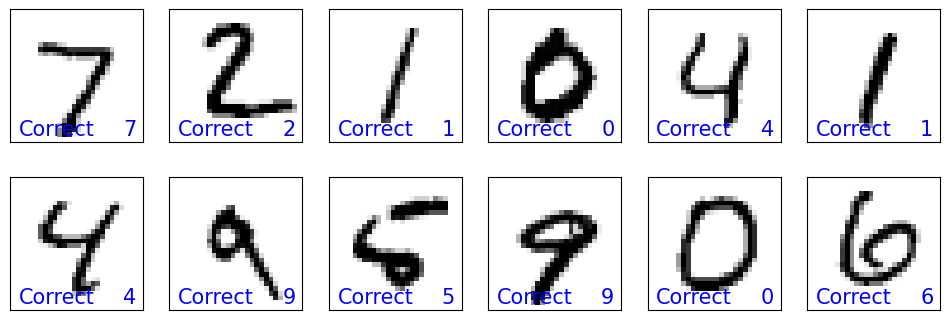

In [11]:
# visual check
with plt.ioff(): # only show the plot when prompted explicitly
    fig = plt.figure(figsize=(12, 4))
    for i in range(12):
        correct = preds[i] == batch_test[1][i]
        ax = fig.add_subplot(2, 6, i+1)
        ax.set_xticks([]); ax.set_yticks([])
        img = batch_test[0][i].view(28, 28)
        ax.imshow(img, cmap='gray_r')
        ax.text(0.9, 0.1, '{}'.format(preds[i]), 
                size=15, color='blue' if correct else 'red',
                horizontalalignment='center',
                verticalalignment='center', 
                transform=ax.transAxes)
        ax.text(0.35, 0.1, '{}'.format('Correct' if correct else 'Incorrect'), 
            size=15, color='blue' if correct else 'red',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
#plt.savefig('figures/15_13.png', dpi=300)
plt.show()

**Challenge**: add code showing misclassifications (is this really a challenge?)

## Gender classification from face images using CNN
---
* Introducing *Data Augmentation*

### Loading the CelebA dataset
* original source: [Chinese University of Hong Kong](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)
* make sure to download the aligned images dataset as well as the attribute list
* the dataset is quite large (about 2GB), and downloading/extracting it may take a while
* we therefore provide a smaller dataset, part of which we will use for our training
* **to do:** download the smaller archive from [here](https://drive.google.com/file/d/1E_kUQ-1-_c3DjnpnR0GgN0gVxRVjc8xx/view?usp=sharing) and unpack it to `data`. This should produce a subdirectory `img_align_celeba_subset/` as well as a text file `list_attr_celeba.txt`
* will subsequently be restricted to 16000 training images and 1000 for validation (to cut training time)

In [12]:
# Preparing the images to be used as a pytorch dataset
image_directory = 'data/img_align_celeba_subset/'
attribute_path = 'data/list_attr_celeba.txt'
attributes = pd.read_csv(attribute_path, skiprows=1, delim_whitespace=True)
attributes.head()

/tmp/ipykernel_12926/2526980710.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  attributes = pd.read_csv(attribute_path, skiprows=1, delim_whitespace=True)


,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [13]:
nmb_img = len([name for name in os.listdir(image_directory) if os.path.isfile(os.path.join(image_directory, name))])
print(f'The subset contains {nmb_img} images')

The subset contains 1 images


In [14]:
# Extracting and re-coding the gender labels from the attribute list
attributes.loc[attributes['Male'] == -1, 'Male'] = 0
gender_labels = attributes['Male'].values
# Extracting single file names from the attribute list
file_names = attributes.index.values

The 1th image is labeled as 0 and looks like this:


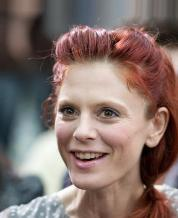

In [16]:
# reading random image
def read_image(image_file):
    image = Image.open(image_directory + image_file)
    return image

rnd_idx = random.randint(1,nmb_img)
print(f'The {rnd_idx}th image is labeled as {gender_labels[rnd_idx]} and looks like this:')
read_image(file_names[rnd_idx])

### Idea: Data Augmentation
* Common problem: not enough images to train network
* Create more data by *modifying* existing images
* Not only applicable on pictures, but other data as well (however, image data is especially well suited)
* Possible approaches:
  * cropping
  * flipping
  * adjusting contrast, brightness, and saturation
* Also a suitable technique if the amount of data is sufficient as it leads to more robust models $\leftarrow$ overfitting is reduced

PyTorch provides a set of predefined methos for transforming and augumenting images (see [PyTorch Transforming and Augumenting Images](https://pytorch.org/vision/main/transforms.html)) 

5 examples using random samples:

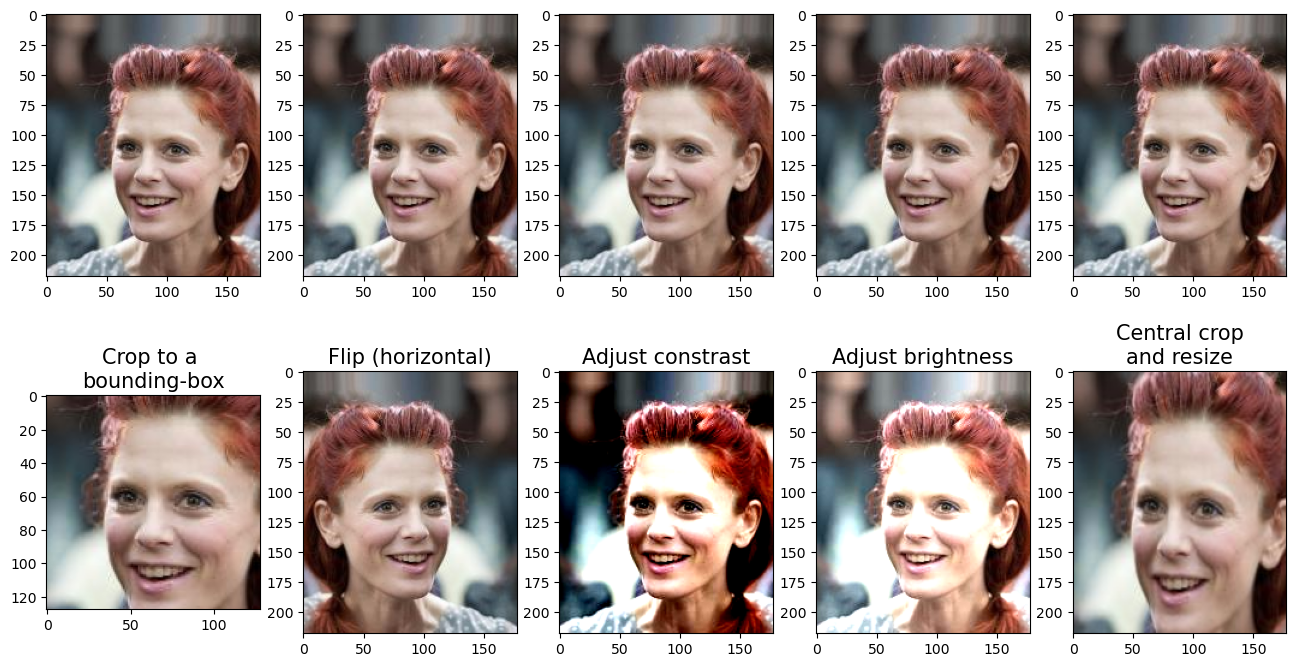

In [17]:
#examples = [read_image(file_names[i]) for i in range(5)]
# let's pick random images
examples = [read_image(file_names[random.randint(1,nmb_img)]) for i in range(5)]

with plt.ioff():
    fig = plt.figure(figsize=(16, 8.5))
    
    ## Column 1: cropping to a bounding-box
    ax = fig.add_subplot(2, 5, 1)
    ax.imshow(examples[0])
    ax = fig.add_subplot(2, 5, 6)
    ax.set_title('Crop to a \nbounding-box', size=15)
    img_cropped = transforms.functional.crop(examples[0], 50, 20, 128, 128)
    ax.imshow(img_cropped)
    
    ## Column 2: flipping (horizontally)
    ax = fig.add_subplot(2, 5, 2)
    ax.imshow(examples[1])
    ax = fig.add_subplot(2, 5, 7)
    ax.set_title('Flip (horizontal)', size=15)
    img_flipped = transforms.functional.hflip(examples[1])
    ax.imshow(img_flipped)
    
    ## Column 3: adjust contrast
    ax = fig.add_subplot(2, 5, 3)
    ax.imshow(examples[2])
    ax = fig.add_subplot(2, 5, 8)
    ax.set_title('Adjust constrast', size=15)
    img_adj_contrast = transforms.functional.adjust_contrast(
        examples[2], contrast_factor=2)
    ax.imshow(img_adj_contrast)
    
    ## Column 4: adjust brightness
    ax = fig.add_subplot(2, 5, 4)
    ax.imshow(examples[3])
    ax = fig.add_subplot(2, 5, 9)
    ax.set_title('Adjust brightness', size=15)
    img_adj_brightness = transforms.functional.adjust_brightness(
        examples[3], brightness_factor=1.5)
    ax.imshow(img_adj_brightness)
    
    ## Column 5: cropping from image center 
    ax = fig.add_subplot(2, 5, 5)
    ax.imshow(examples[4])
    ax = fig.add_subplot(2, 5, 10)
    ax.set_title('Central crop\nand resize', size=15)
    img_center_crop = transforms.functional.center_crop(
        examples[4], output_size=(150, 150))
    img_resized = transforms.functional.resize(
        img_center_crop, size=(218, 178))
    ax.imshow(img_resized)

# plt.savefig('figures/15_14.png', dpi=300)
plt.show()

#### Expansion of existing data through random transformation and augmentation

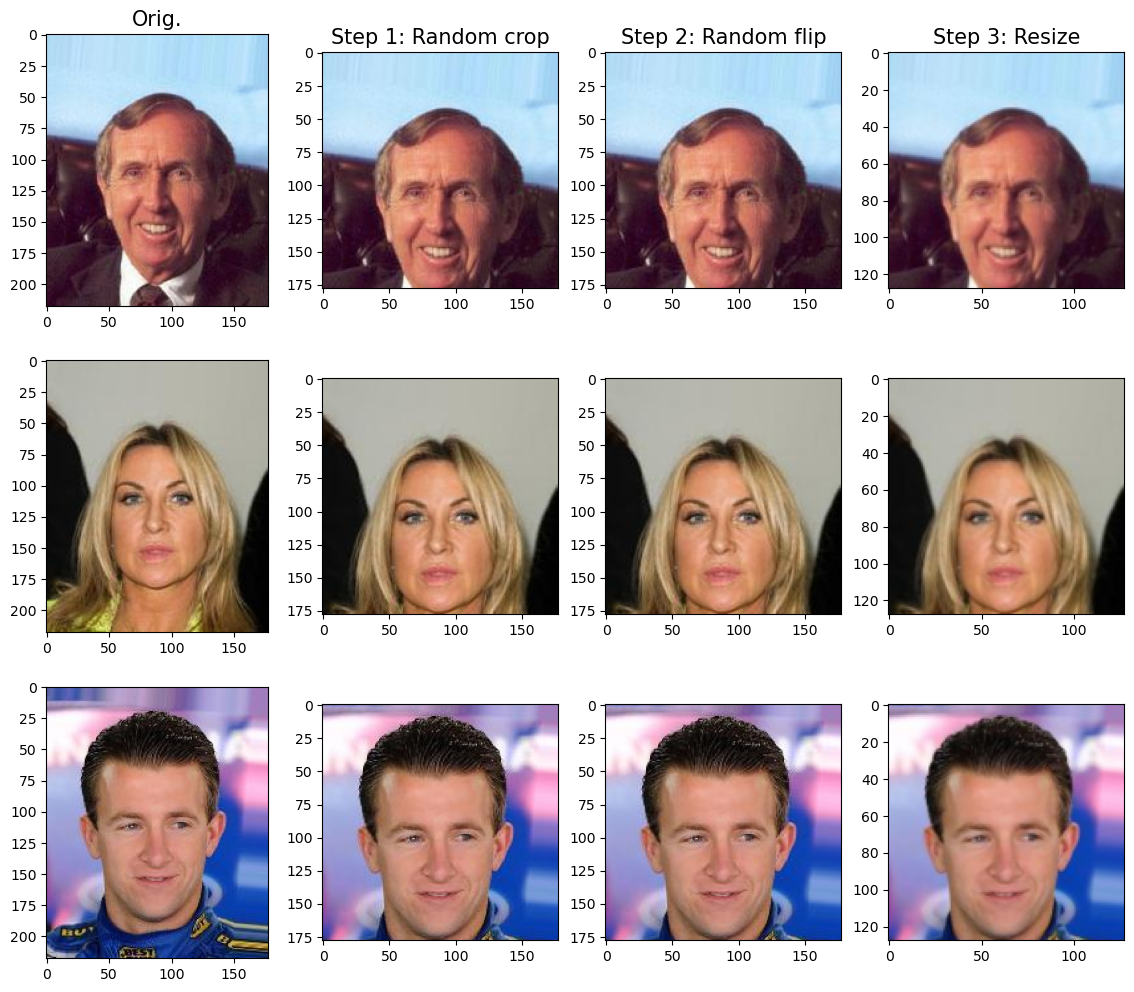

In [18]:
#define random augmenation operations
random_crop = transforms.RandomCrop(size=(178, 178))
random_h_flip = transforms.RandomHorizontalFlip(p=0.5)

#load a few examples
examples = [read_image(file_names[i]) for i in range(20, 23)]

with plt.ioff():
    fig = plt.figure(figsize=(14, 12))
    
    for i, image in enumerate(examples):
        ax = fig.add_subplot(3, 4, i*4+1)
        ax.imshow(image)
        if i == 0:
            ax.set_title('Orig.', size=15)
    
        ax = fig.add_subplot(3, 4, i*4+2)
        img_crop = random_crop(image)
        ax.imshow(img_crop)
        if i == 0:
            ax.set_title('Step 1: Random crop', size=15)
    
        ax = fig.add_subplot(3, 4, i*4+3)
        img_flip = random_h_flip(img_crop)
        ax.imshow(img_flip)
        if i == 0:
            ax.set_title('Step 2: Random flip', size=15)
    
        ax = fig.add_subplot(3, 4, i*4+4)
        img_resize = transforms.functional.resize(img_flip, size=(128, 128))
        ax.imshow(img_resize)
        if i == 0:
            ax.set_title('Step 3: Resize', size=15)

# plt.savefig('figures/15_15.png', dpi=300)
plt.show()

In [19]:
# define Dataset
class CelebADataset(Dataset):
    
    def __init__(self, data, transform = None, augumentation=None, is_train=True):
        self.data = data
        self.transform = transform
        self.augumentation = augumentation
        self.is_train = is_train
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #read image
        image_file, label = self.data[idx]
        #convert label to tensor
        label = torch.tensor([label]).float()
        image = read_image(image_file)
        # only apply augumentation if is training set
        if self.augumentation is not None and self.is_train:
            image = self.augumentation(image)
        if self.transform is not None:
            image = transform(image)
        return image, label
        

# define pre-processing and augumentation

# we can compose multiple transformation steps into a transformation pipeline
transform = transforms.Compose([
    #rescale to (64/64)
    transforms.Resize(size=(64, 64), antialias=True),
    #convert image to tensor and normalize it
    transforms.ToTensor(),
])  

augment = transforms.Compose([
    #define the augumentation operation
    transforms.RandomCrop(size=(178, 178)),
    transforms.RandomHorizontalFlip(p=0.5)
])  

train_size = 16000
valid_size = 5000
test_size = 1000 

celeb_a_train, celeb_a_valid, celeb_a_test = random_split(list(zip(file_names, gender_labels))[:22000], [train_size, valid_size, test_size])
celeb_a_dataset_train = CelebADataset(celeb_a_train, transform=transform, augumentation=augment, is_train=True)
celeb_a_dataset_valid = CelebADataset(celeb_a_valid, transform=transform, augumentation=augment, is_train=False)
celeb_a_dataset_test = CelebADataset(celeb_a_test, transform=transform, augumentation=augment, is_train=False)

print(f'Len train dataset: {len(celeb_a_dataset_train)} -- Len val dataset: {len(celeb_a_dataset_valid)} -- Len test dataset: {len(celeb_a_dataset_test)}')

Len train dataset: 16000 -- Len val dataset: 5000 -- Len test dataset: 1000


### Prepare training

In [20]:
BATCH_SIZE = 64

celeb_a_trainloader = DataLoader(celeb_a_dataset_train, batch_size=BATCH_SIZE, shuffle=True)
celeb_a_testloader = DataLoader(celeb_a_dataset_valid, batch_size=BATCH_SIZE, shuffle=False)
celeb_a_valloader = DataLoader(celeb_a_dataset_test, batch_size=BATCH_SIZE, shuffle=False)

Note that it makes no sense to *shuffle* the validation data or test data, while shuffling in the training phase and therefore presenting the images to the model in a different order and in different batches does influence the learning process.

### Training a CNN gender classifier

* **Global Average Pooling** $\rightarrow$ one output per channel

<img src="./img/15_13.png" width=800/>

* again, see [Jason Brownlee's blog](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/) for background
* may be viewed as an alternative to fully connected layers with the added benefit of not being prone to overfitting as explained in the [original paper](https://arxiv.org/pdf/1312.4400.pdf)

In [21]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout(p=0.5)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        
        x = self.conv4(x)
        x = self.relu4(x)
        
        x = self.global_avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        # Using the sigmoidal acitvation function to squeeze the output into the range [0, 1]
        x = torch.sigmoid(x)
        return x

Instantiating and showing the model:

In [22]:
#create an instance of the model
model = CNN()
model

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (global_avgpool): AdaptiveAvgPool2d(output_size=1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

### Performing the (initial) Training

In [23]:
NUM_EPOCHS = 10
start_train_celeb_a = dt.datetime.now()

# Set the device for training
device = torch.device("cuda" if torch.cuda.is_available() and USE_GPU else "cpu")
print(f'Using {device} for training the network')

# Move the model weight to the desired device
model.to(device)

# Define the loss function (a different one this time ...)
criterion = nn.BCELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters())

# run training, set binary to true since we have a binary classification
history = train_for_epochs(device, NUM_EPOCHS, model, celeb_a_trainloader, celeb_a_valloader, optimizer, criterion, binary=True)

finish_train_celeb_a = dt.datetime.now()
print(f'Celeb A training finished: {finish_train_celeb_a} (duration: {finish_train_celeb_a - start_train_celeb_a})')

Using cuda for training the network


  0%|          | 0/10 [00:00<?, ?it/s]

Celeb A training finished: 2024-01-28 22:07:47.747453 (duration: 0:02:15.369309)


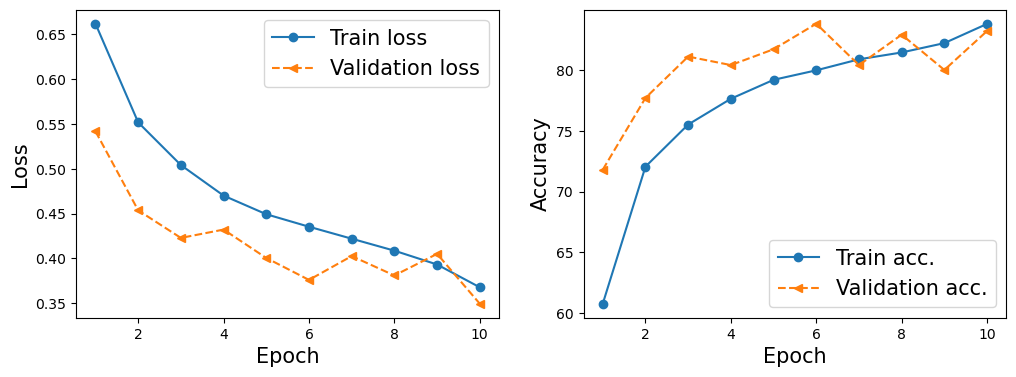

In [24]:
loss_train_hist = history['train']['loss']
acc_train_hist = history['train']['accuracy']
loss_val_hist = history['val']['loss']
acc_val_hist = history['val']['accuracy']

plot_history(loss_train_hist, acc_train_hist, loss_val_hist, acc_val_hist)
plt.show()

Both training as well as validation accuracy still go up, so the model still seems to be learning general concepts and not just memorize the training data. It might therefore make sense to continue training ...

#### Performance assessment: model quality on unseen data

In [25]:
test_loss, test_accuracy = validate(device, model, celeb_a_testloader, criterion, binary=True)
print('\nTest Acc. {:.2f}%'.format(test_accuracy))


Test Acc. 82.90%


### Resuming training
* You can just continue the training loop to resume training for additional epochs
* Also possible by [saving and later on loading](https://pytorch.org/tutorials/beginner/saving_loading_models.html) models

In [26]:
start_train = dt.datetime.now()
print(f'CelebA training resumed: {start_train}')
# run training for additional 5 epochs
NUM_ADD_EPOCHS = 5
history = train_for_epochs(device, NUM_ADD_EPOCHS, model, celeb_a_trainloader, celeb_a_valloader, optimizer, criterion, binary=True)
finish_train = dt.datetime.now()
print(f'CelebA resumed training finished: {finish_train} (duration: {finish_train - start_train})')

CelebA training resumed: 2024-01-28 22:07:51.266991


  0%|          | 0/5 [00:00<?, ?it/s]

CelebA resumed training finished: 2024-01-28 22:08:59.421361 (duration: 0:01:08.154370)


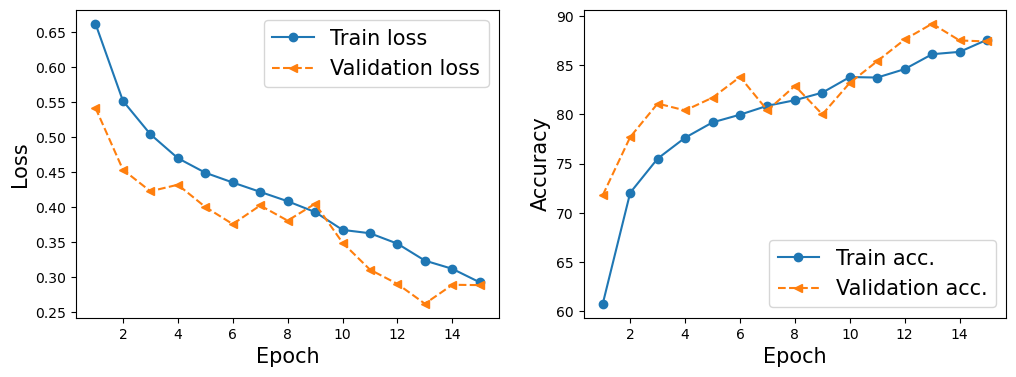

In [27]:
loss_train_hist_add = history['train']['loss']
acc_train_hist_add = history['train']['accuracy']
loss_val_hist_add = history['val']['loss']
acc_val_hist_add = history['val']['accuracy']

loss_train_hist += loss_train_hist_add
acc_train_hist += acc_train_hist_add
loss_val_hist += loss_val_hist_add
acc_val_hist += acc_val_hist_add

plot_history(loss_train_hist, acc_train_hist, loss_val_hist, acc_val_hist)
plt.show()

In [28]:
test_loss, test_accuracy = validate(device, model, celeb_a_testloader, criterion, binary=True)
print('\nTest Acc. {:.2f}%'.format(test_accuracy))


Test Acc. 87.06%


So, indeed the continuation was worth it and one might even try to go on further.

#### Classification of images
using 10 images from the test dataset to get a feeling for the model quality

In [29]:
batch_test = next(iter(celeb_a_testloader))

# see code for predict_batch in MNIST part of notebook above
preds, probas = predict_batch(model, batch_test[0][:10], binary=True)
probas = probas.cpu().numpy().flatten() * 100

print(probas)

[99.709404  79.7211    57.0629     1.9668771  5.5073466 35.739193
 99.66734   90.69047   98.18391   31.162241 ]


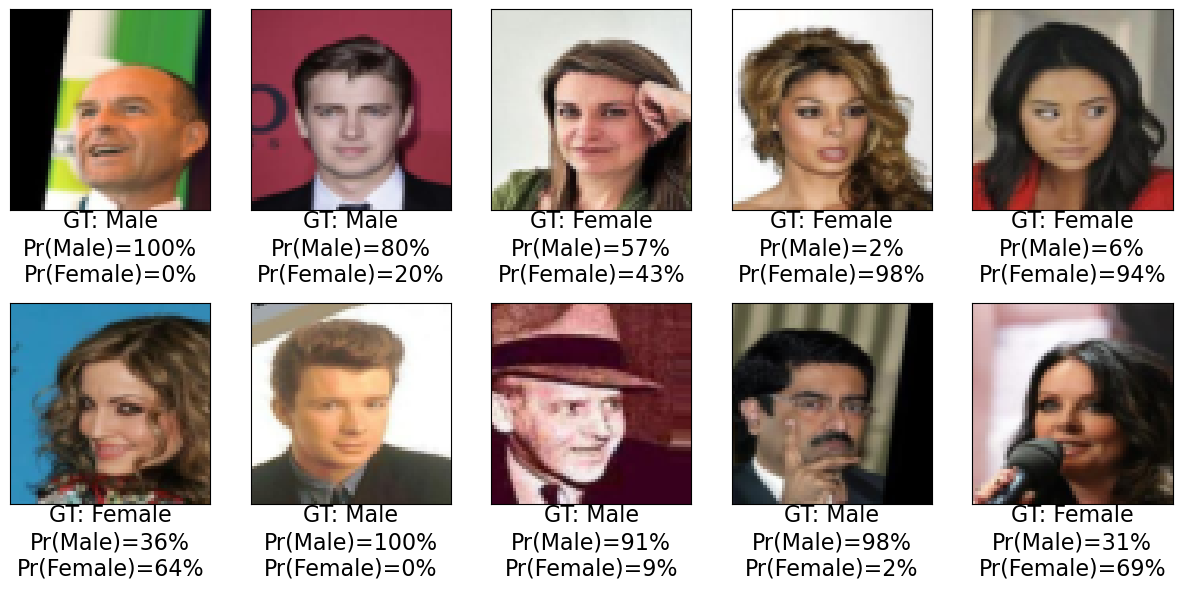

In [30]:
# perform a visual check
images = batch_test[0]
labels = batch_test[1]

with plt.ioff():
    fig = plt.figure(figsize=(15, 7))
    for j in range(10):
    
        ax = fig.add_subplot(2, 5, j+1)
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(images[j].transpose(2, 0).transpose(0, 1))
        if labels[j].cpu().numpy() == 1:
            label='Male'
        else:
            label = 'Female'
        ax.text(
            0.5, -0.19, 
            'GT: {:s}\nPr(Male)={:.0f}%\nPr(Female)={:.0f}%'.format(label, probas[j], 100 - probas[j]), 
            size=16, 
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
#plt.savefig('figures/figures-15_19.png', dpi=300)
plt.show()

## Learning Outcomes
---

The contents presented here were mostly geared towards the popular deep learning application of object recognition (in images). Having worked through this notebook, you should now

* have a firm grasp on the concepts involved with convolutional neural networks;
* know about the fundamental building blocks a CNN typically consists of, including feature maps and how to build them;
* be able to perform regularization on neural networks by utilizing Dropout;
* know about the concept of Data Augmentation and how to apply it to image data;
* have the ability to build convolutional neural networks on your own with the help of ```PyTorch```.